In [40]:
### Loading Libraries 
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import random
import math
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', 101)

### Preliminary Data Handling

In [2]:
### Loading in data from Excel file
xls = pd.ExcelFile('Scholastic_AssociateDataScience_CaseStudy_Data.xlsx')
### Loading the seperate sheets of the excel file
mag_df = pd.read_excel(xls, 1)
buil_df = pd.read_excel(xls, 2)
club_df = pd.read_excel(xls, 3)
ed_df = pd.read_excel(xls, 4)

In [3]:
### Checking dimensions of sheets
print(mag_df.shape)
print(buil_df.shape)
print(club_df.shape)
print(ed_df.shape)

(101136, 5)
(51793, 20)
(140349, 3)
(94470, 3)


#### All NA's are from the building dataframe.  Majority of these NA's come from the reading performance and the b_pct columns

In [4]:
### Checking NA's
print(mag_df.isnull().sum())
print(buil_df.isnull().sum())
print(club_df.isnull().sum())
print(ed_df.isnull().sum())

school_year      0
building_id      0
teacher_count    0
paid_quantity    0
order_amount     0
dtype: int64
building_id                         0
mailing_state                       1
enrollment                          0
b_indicator_charter                 0
b_indicator_catholic                0
b_indicator_private                 0
b_indicator_public                  0
reading_performance_grd_3_pct    4672
reading_performance_grd_4_pct    4672
reading_performance_grd_5_pct    4672
reading_performance_grd_6_pct    4672
reading_performance_grd_7_pct    4672
reading_performance_grd_8_pct    4672
b_pct_aa                         4672
b_pct_as                         4672
b_pct_wa                         4672
b_pct_ha                         4672
b_pct_t1                         4672
b_census_hhi                      577
b_census_urbanicity               523
dtype: int64
building_id     0
school_year     0
bookclub_rev    0
dtype: int64
building_id         0
school_year         0
revenue_

Left joining all sheets with magazine sheet as this will retain all information with regards to the magazine business' request 

In [5]:
### Joining magazine data sheets to sheet with building information
df = mag_df.merge(buil_df,on='building_id', how = 'left')

In [6]:
### Joining magazine and building data with other revenue data by building id and school_year
df = df.merge(club_df, on = ['building_id', 'school_year'], how = 'left').merge(ed_df, on = ['building_id','school_year'], how = 'left')

In [7]:
### Checking dimensions to ensure proper joins of final dataset
print(df.shape) #retained all rows and info from magazine dataset

(101136, 26)


## Question 1. EDA

Exploring the data to find characteristics of buildings that correspond to the most paid quantity decrease (Loss).

### Descriptive statistics & null values

In [8]:
### Checking NA's, majority of NA's in revenue_ed_group ~1/3 of which is missing
print(df.isnull().sum())

school_year                          0
building_id                          0
teacher_count                        0
paid_quantity                        0
order_amount                         0
mailing_state                      818
enrollment                         818
b_indicator_charter                818
b_indicator_catholic               818
b_indicator_private                818
b_indicator_public                 818
reading_performance_grd_3_pct     3069
reading_performance_grd_4_pct     3069
reading_performance_grd_5_pct     3069
reading_performance_grd_6_pct     3069
reading_performance_grd_7_pct     3069
reading_performance_grd_8_pct     3069
b_pct_aa                          3069
b_pct_as                          3069
b_pct_wa                          3069
b_pct_ha                          3069
b_pct_t1                          3069
b_census_hhi                      1643
b_census_urbanicity               1573
bookclub_rev                      2144
revenue_ed_group         

In [9]:
# listing data types
df.dtypes

school_year                        int64
building_id                        int64
teacher_count                      int64
paid_quantity                      int64
order_amount                     float64
mailing_state                     object
enrollment                       float64
b_indicator_charter              float64
b_indicator_catholic             float64
b_indicator_private              float64
b_indicator_public               float64
reading_performance_grd_3_pct    float64
reading_performance_grd_4_pct    float64
reading_performance_grd_5_pct    float64
reading_performance_grd_6_pct    float64
reading_performance_grd_7_pct    float64
reading_performance_grd_8_pct    float64
b_pct_aa                         float64
b_pct_as                         float64
b_pct_wa                         float64
b_pct_ha                         float64
b_pct_t1                         float64
b_census_hhi                     float64
b_census_urbanicity               object
bookclub_rev    

In [10]:
# Summary statistics
df.describe()

,school_year,building_id,teacher_count,paid_quantity,order_amount,enrollment,b_indicator_charter,b_indicator_catholic,b_indicator_private,b_indicator_public,reading_performance_grd_3_pct,reading_performance_grd_4_pct,reading_performance_grd_5_pct,reading_performance_grd_6_pct,reading_performance_grd_7_pct,reading_performance_grd_8_pct,b_pct_aa,b_pct_as,b_pct_wa,b_pct_ha,b_pct_t1,b_census_hhi,bookclub_rev,revenue_ed_group
count,101136.000000,1.011360e+05,101136.000000,101136.000000,101136.000000,100318.000000,100318.000000,100318.000000,100318.000000,100318.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,99493.000000,98992.000000,68554.000000
mean,2017.990577,6.020208e+08,6.700838,267.362245,1301.815403,463.040770,0.023784,0.014623,0.028469,0.932315,43.519849,43.351066,40.273507,10.103388,0.546208,0.472351,11.684083,5.343755,54.223612,23.053045,47.435284,59838.055753,3135.627217,1656.157605
std,0.816065,7.263141e+06,7.465864,273.728551,1397.988711,219.190078,0.152377,0.120041,0.166311,0.251205,26.314808,26.699804,28.994536,22.357303,5.604781,5.137985,19.158347,10.864584,33.567692,25.605170,29.405326,24487.657024,2859.551757,5872.272046
min,2017.000000,6.000302e+08,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9475.000000,0.000000,-39604.260000
25%,2017.000000,6.000589e+08,1.000000,65.000000,266.500000,314.000000,0.000000,0.000000,0.000000,1.000000,26.000000,25.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,22.000000,5.000000,23.000000,42695.000000,1201.500000,53.800000
50%,2018.000000,6.000858e+08,4.000000,182.000000,825.000000,442.000000,0.000000,0.000000,0.000000,1.000000,47.000000,47.000000,44.000000,0.000000,0.000000,0.000000,3.000000,1.000000,61.000000,12.000000,46.000000,53939.000000,2419.000000,190.565000
75%,2019.000000,6.001238e+08,10.000000,387.000000,1919.950000,590.000000,0.000000,0.000000,0.000000,1.000000,64.000000,64.000000,64.000000,0.000000,0.000000,0.000000,13.000000,5.000000,85.000000,33.000000,70.000000,71786.000000,4258.942500,847.985000
max,2019.000000,8.199552e+08,70.000000,5600.000000,18991.510000,3537.000000,1.000000,1.000000,1.000000,1.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,230952.000000,73955.000000,218306.200000


In [11]:
#Checking for duplicates, No duplicates
df.duplicated().sum()

0

### Initial feature creation

Creating change in paid quantity variable, with first year values set to 0.

In [12]:
### Creating change in paid quantity variable
df['chg_pd_qty'] = df.groupby(['building_id']).paid_quantity.diff().fillna(0)

Cannot get reliable information on outliers from the box plot below as all first year values were set to 0 decreasing interquartile range.

count    101136.000000
mean         -1.019014
std         123.048403
min       -5383.000000
25%          -5.000000
50%           0.000000
75%           7.000000
max        3085.000000
Name: chg_pd_qty, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='chg_pd_qty', ylabel='Density'>

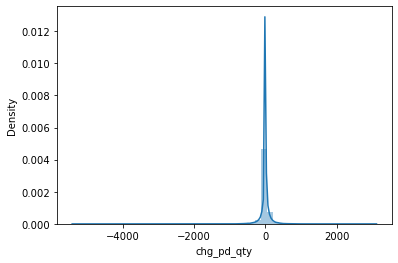

In [13]:
### Checking distribution for new variable
print(df.chg_pd_qty.describe())
sns.distplot(df.chg_pd_qty)

Below we see that the new variable chg_pd_qty looks good

In [14]:
### Checking new variable first 25 buildings
n_groupby = 0
for key, item in df.groupby(['building_id']):
    while n_groupby < 25:
        print(df[['building_id','school_year','chg_pd_qty','paid_quantity']].groupby(['building_id']).get_group(key), "\n\n")
        n_groupby +=1
### New variable looks good

       building_id  school_year  chg_pd_qty  paid_quantity
0        600030153         2017         0.0             61
34157    600030153         2018        40.0            101
67932    600030153         2019       -45.0             56 


       building_id  school_year  chg_pd_qty  paid_quantity
0        600030153         2017         0.0             61
34157    600030153         2018        40.0            101
67932    600030153         2019       -45.0             56 


       building_id  school_year  chg_pd_qty  paid_quantity
0        600030153         2017         0.0             61
34157    600030153         2018        40.0            101
67932    600030153         2019       -45.0             56 


       building_id  school_year  chg_pd_qty  paid_quantity
0        600030153         2017         0.0             61
34157    600030153         2018        40.0            101
67932    600030153         2019       -45.0             56 


       building_id  school_year  chg_pd_qty 

We see above that not all schools have data for all 3 years. Making the assumption that a missing value for a given building does not necessarily mean a paid quantity of 0.

### Univariate Analysis

2017    34157
2018    33775
2019    33204
Name: school_year, dtype: int64



<AxesSubplot:xlabel='school_year', ylabel='count'>

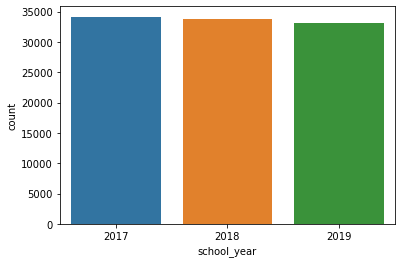

In [15]:
# Checking value counts of relevant variables and plotting
print(df['school_year'].value_counts(), end = '\n\n')# Fairly uniform
sns.countplot(x='school_year', data=df)

RURAL       52186
SUBURBAN    34843
URBAN       12534
Name: b_census_urbanicity, dtype: int64



<AxesSubplot:xlabel='b_census_urbanicity', ylabel='count'>

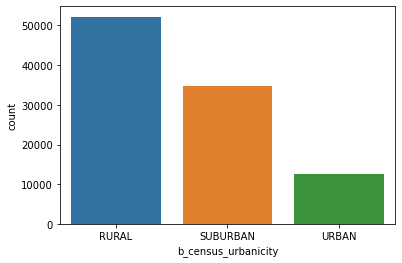

In [16]:
print(df['b_census_urbanicity'].value_counts(), end = '\n\n') 
sns.countplot(x='b_census_urbanicity', data=df)

No major issues with insufficient counts in each category, could potentially combine suburban and urban categories to get more balanced variable if it helps improve modelling.

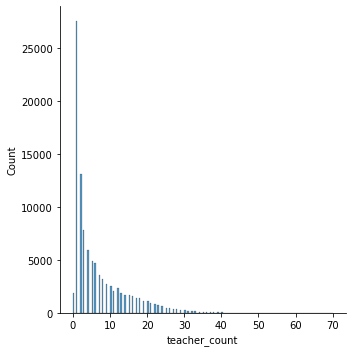

In [17]:
sns.displot(df.teacher_count) #Skewed distribution

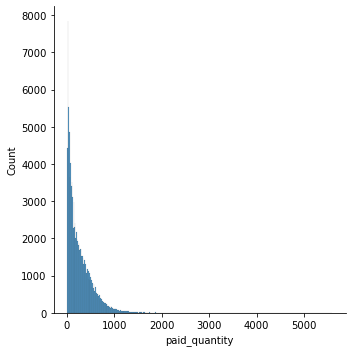

In [18]:
sns.displot(df.paid_quantity) #skewed Distribution

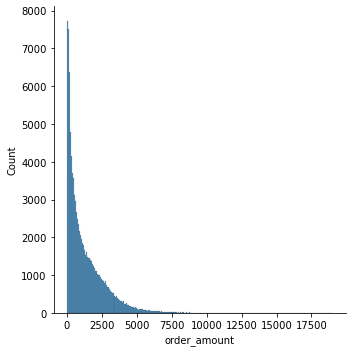

In [19]:
sns.displot(df.order_amount) #skewed distribution

We have multiple skewed distributions but they should not be an issue as long as there is a linear relationship between these variables and the dependent variable in the case of logistic regression.

### Bivariate and Multivariate Analysis

Trying to see the relationships between variables and change in paid quantity.

Creating a dataframe that excludes data from 2017 as these have the variable change in paid quantity initialized to zero. This is merely for visualization and Exploratory data analysis.

In [20]:
df_no_2017 = df.loc[df['school_year'].isin([2018,2019])]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='b_census_hhi', ylabel='chg_pd_qty'>

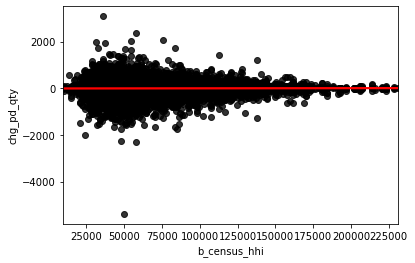

In [21]:
#Using all data and then df only 2017 to see if there is a difference
sns.regplot(df.b_census_hhi, df.chg_pd_qty, fit_reg = True, scatter_kws={"color": "black"}, line_kws={"color": "red"})


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='b_census_hhi', ylabel='chg_pd_qty'>

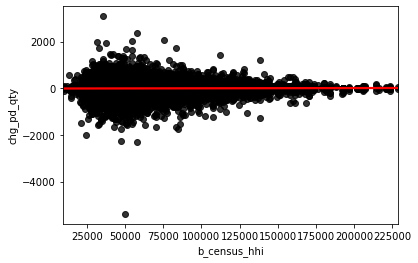

In [22]:
# Without 0 values
sns.regplot(df_no_2017.b_census_hhi, df_no_2017.chg_pd_qty, fit_reg = True, scatter_kws={"color": "black"}, line_kws={"color": "red"})

<AxesSubplot:xlabel='b_census_urbanicity', ylabel='chg_pd_qty'>

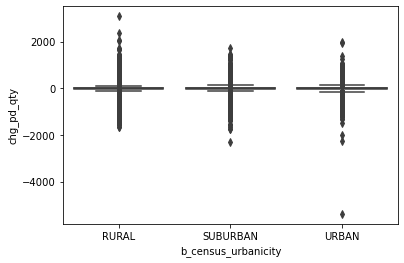

In [23]:
sns.boxplot(x = df_no_2017.b_census_urbanicity, y = df_no_2017.chg_pd_qty) #although barely visible appears to be an affect.

<AxesSubplot:xlabel='b_indicator_public', ylabel='chg_pd_qty'>

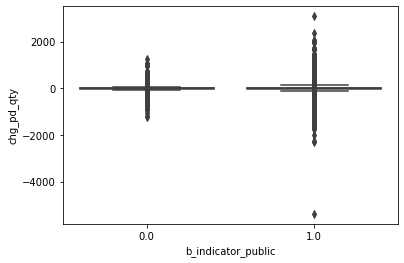

In [24]:
sns.boxplot(x = df_no_2017.b_indicator_public, y = df_no_2017.chg_pd_qty)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='teacher_count', ylabel='chg_pd_qty'>

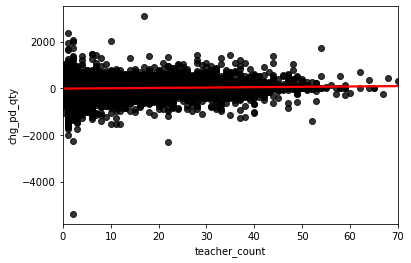

In [25]:
sns.regplot(df.teacher_count, df.chg_pd_qty, fit_reg = True, scatter_kws={"color": "black"}, line_kws={"color": "red"})

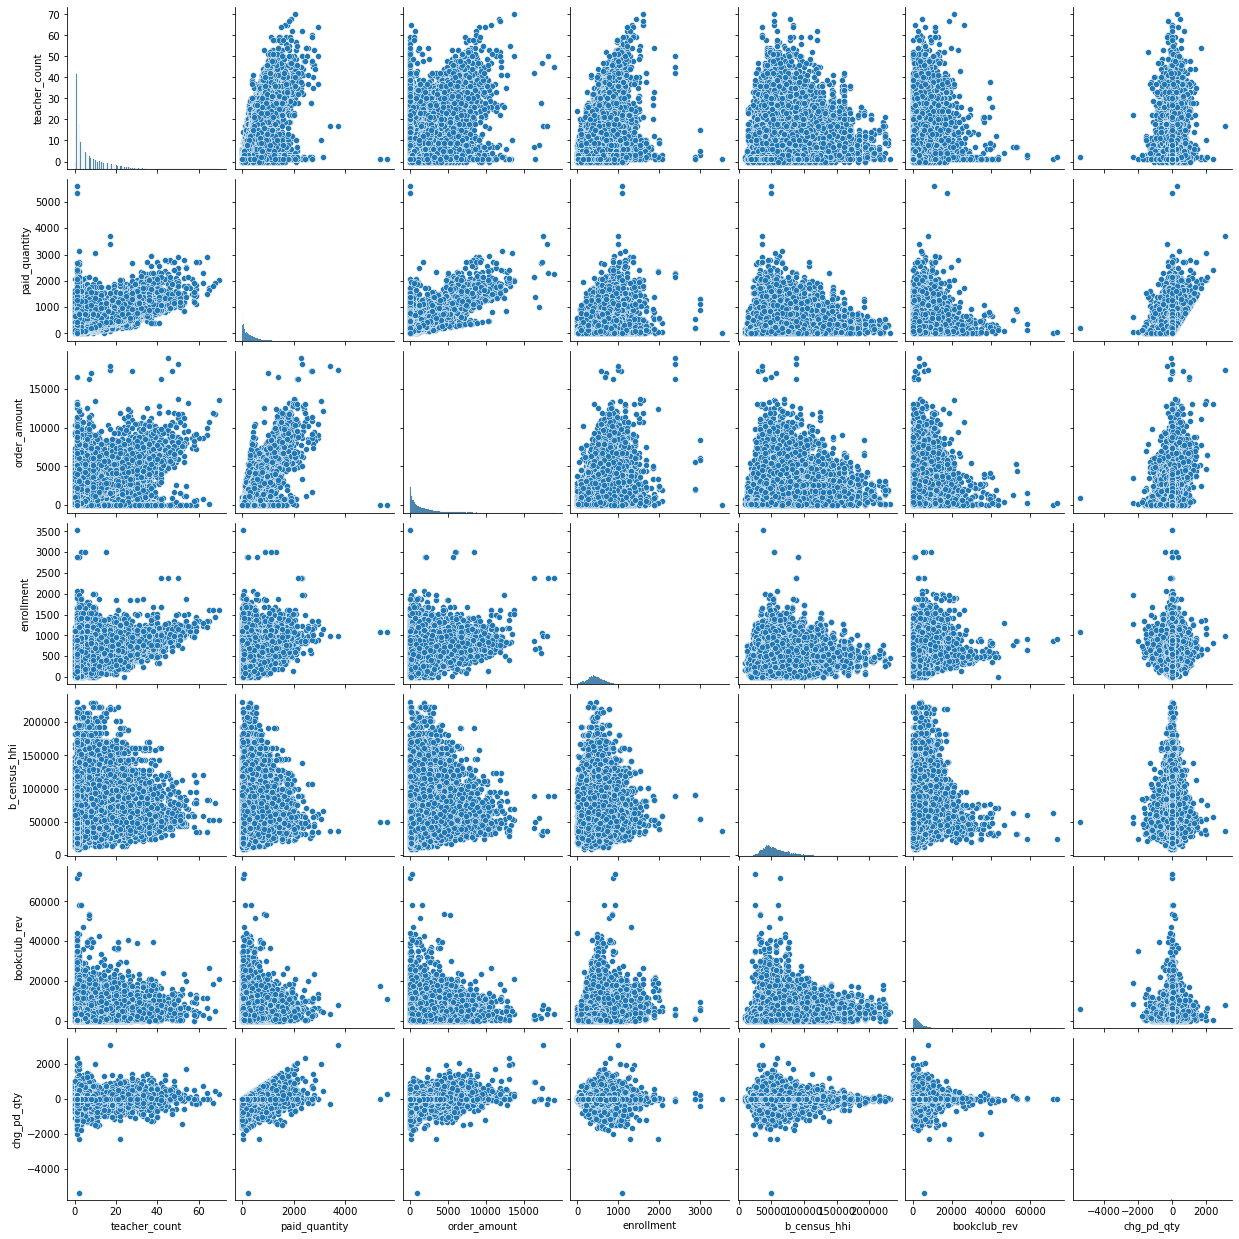

In [26]:
sns.pairplot(df[['teacher_count','paid_quantity','order_amount','enrollment','b_census_hhi','bookclub_rev','chg_pd_qty']])

From the above pair plot we see some relationship between teacher count and paid amount. Creating a new variable called change in teacher count and including it in a correlation matrix below

In [27]:
# Creating new variable chg_teacher_cnt
df['chg_teacher_cnt'] = df.groupby(['building_id']).teacher_count.diff().fillna(0)

Creating a correlation matrix of all variables excluding categorical, indicator, and percentage variables.

<AxesSubplot:>

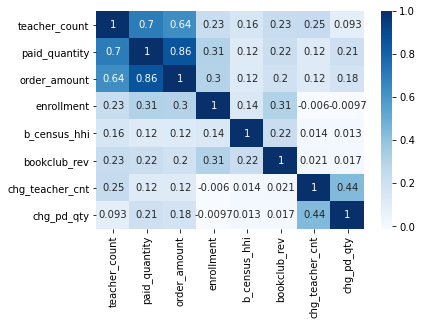

In [28]:
sns.heatmap(df[['teacher_count','paid_quantity','order_amount','enrollment','b_census_hhi','bookclub_rev',\
                'chg_teacher_cnt','chg_pd_qty']].corr(), cmap='Blues', annot = True)


### Summary

From the initial EDA and data preprocessing we see that the data is relatively clean and was able to be joined with magazine data leaving minimal NA's. One column to look at however was the revenue_ed_group column which had ~33% NA's.  
I made the assumption that loss corresponds to decrease in paid quantity and created a variable called change in paid quantity. This is what I used for a majority of the EDA. First, I looked at the distributions of certain variables which were skewed. These will need to be normalized for certain predictions under linear models. Second, I tried identifying variables that had a relationship with change in paid amount. This did not show many clear outcomes even when disregarding the initial 0 values from 2017. The majority of findings came from the pair plot and correlation matrix from which we can see that:  
1) Change in teacher count is moderately correlated with change in paid quantity.  
2) Teacher count and paid quantity are highly correlated.
3) Enrollment and paid quantity are moderately correlated.


## Question 2. Modeling

Choosing option (ii) for part A. Specifically, building a model which predicts the paid quantity of a building in order to identify and interpret the most important features in prediction. This could help focus resources on promoting/pursuing schools with such features.

### Handling missing data

In [29]:
# As 1/3rd of revenue_ed_group is missing we will drop the column, could potentially impute in the future
sum(df.revenue_ed_group.isna())
df.drop('revenue_ed_group', inplace=True, axis=1)

In [30]:
# Removing rows with NA data as they are highly correlated with each other and removing these rows shouldnt be harmful, retain 95% of data
df = df.dropna()
df.shape

(95564, 27)

### Further feature creation

Adding change in order amount, and change in book club revenue for building id each year. 

In [31]:
df['chg_order_amt'] = df.groupby(['building_id']).order_amount.diff().fillna(0)
df['chg_bookclub_rev'] = df.groupby(['building_id']).bookclub_rev.diff().fillna(0)

In [32]:
df[['chg_teacher_cnt','chg_order_amt', 'chg_bookclub_rev']].describe()

,chg_teacher_cnt,chg_order_amt,chg_bookclub_rev
count,95564.000000,95564.000000,95564.000000
mean,0.034752,34.995951,-327.140628
std,3.505232,644.139648,1315.029932
min,-64.000000,-15321.960000,-46593.250000
25%,0.000000,0.000000,-642.500000
50%,0.000000,0.000000,0.000000
75%,0.000000,84.185000,0.000000
max,57.000000,14805.460000,40013.250000


### Final dataset and features

In [33]:
df.head()

,school_year,building_id,teacher_count,paid_quantity,order_amount,mailing_state,enrollment,b_indicator_charter,b_indicator_catholic,b_indicator_private,b_indicator_public,reading_performance_grd_3_pct,reading_performance_grd_4_pct,reading_performance_grd_5_pct,reading_performance_grd_6_pct,reading_performance_grd_7_pct,reading_performance_grd_8_pct,b_pct_aa,b_pct_as,b_pct_wa,b_pct_ha,b_pct_t1,b_census_hhi,b_census_urbanicity,bookclub_rev,chg_pd_qty,chg_teacher_cnt,chg_order_amt,chg_bookclub_rev
0,2017,600030153,1,61,339.95,AL,293.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46433.0,RURAL,3468.5,0.0,0.0,0.0,0.0
1,2017,600030160,5,145,903.25,AL,178.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35726.0,RURAL,3358.0,0.0,0.0,0.0,0.0
2,2017,600030189,4,68,357.00,AL,630.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55560.0,SUBURBAN,3766.0,0.0,0.0,0.0,0.0
3,2017,600030227,1,88,326.92,AL,471.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40817.0,SUBURBAN,1853.0,0.0,0.0,0.0,0.0
4,2017,600030248,1,20,64.90,AL,110.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61652.0,RURAL,978.0,0.0,0.0,0.0,0.0


Choosing all variables as predictors except for building_id (goal of identifying specific features and not specific buildings), change in paid quantity(potential value to be predicted), change in order amount/ order amount(correlated with value we wish to predict), school year (more robust model able to predict outside narrow year range), and mailing_state (variable is unbalanced and greatly increases complexity). 

In [34]:
### Correlation between order amount and paid quantity
df.order_amount.corr(df.paid_quantity)

0.8560563442177513

Adding dummies required for categorical variables

In [35]:
X = df.drop(['school_year', 'building_id', 'chg_order_amt', 'order_amount','chg_pd_qty', 'paid_quantity', 'mailing_state'], axis =1)
X_dummies = pd.get_dummies(X, drop_first = True)
y = df.paid_quantity
X_dummies.head()

,teacher_count,enrollment,b_indicator_charter,b_indicator_catholic,b_indicator_private,b_indicator_public,reading_performance_grd_3_pct,reading_performance_grd_4_pct,reading_performance_grd_5_pct,reading_performance_grd_6_pct,reading_performance_grd_7_pct,reading_performance_grd_8_pct,b_pct_aa,b_pct_as,b_pct_wa,b_pct_ha,b_pct_t1,b_census_hhi,bookclub_rev,chg_teacher_cnt,chg_bookclub_rev,b_census_urbanicity_SUBURBAN,b_census_urbanicity_URBAN
0,1,293.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46433.0,3468.5,0.0,0.0,0,0
1,5,178.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35726.0,3358.0,0.0,0.0,0,0
2,4,630.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55560.0,3766.0,0.0,0.0,1,0
3,1,471.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40817.0,1853.0,0.0,0.0,1,0
4,1,110.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61652.0,978.0,0.0,0.0,0,0


Splitting data into test and train data

In [36]:
# set seed
random.seed(27)
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(64027, 23) (31537, 23) (64027,) (31537,)


Building a intial linear regression model to see viability

<AxesSubplot:xlabel='paid_quantity', ylabel='Density'>

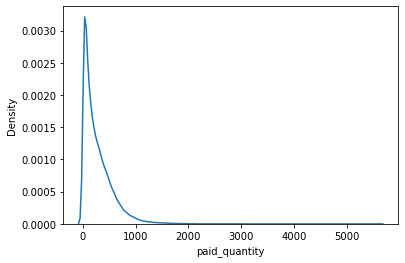

In [37]:
### Checking distribution of y
sns.kdeplot(y)

<AxesSubplot:xlabel='paid_quantity', ylabel='Density'>

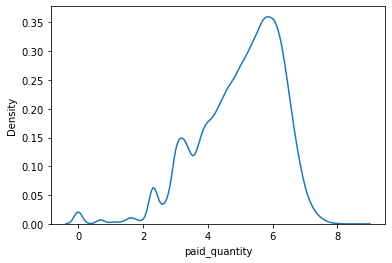

In [38]:
### As distribution of y is skewed we will perform a log transform to make it closer to normal
y_log = np.log(y)
sns.kdeplot(y_log)

In [41]:
### Scale the data 
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, np.log(y_train))  # apply scaling on training data, using log transformation on y

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [42]:
# evaluate the model
print('R-Squared value:', pipe.score(X_test, np.log(y_test))) ### R^2 Value
# evaluate predictions
mse = mean_squared_error(y_test, np.exp(pipe.predict(X_test))) # converting the log predictions back by np.exp
print('RMSE: %.4f' % np.sqrt(mse))

R-Squared value: 0.4117847280059421
RMSE: 775.7034


Choosing another model type for primary prediction and interpretation as RMSE value is extremely high.

Building the tree based model, XG boost, to compare to the linear regression model

In [43]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Initial cross validated model to see viability of XGboost

In [44]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=27)

In [45]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,367.395131,1.632652,367.503408,3.524485
1,344.069773,3.690442,344.239797,6.648499
2,323.558879,4.708670,323.695068,3.556477
3,311.100444,4.894509,311.364512,3.627674
4,297.432800,3.728495,297.863810,6.460150


In [46]:
print((cv_results["test-rmse-mean"]).tail(1))

49    192.063731
Name: test-rmse-mean, dtype: float64


In [ ]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
xgbr = xgb.XGBRegressor(objective ='reg:squarederror',seed = 27)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [ ]:
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
print('RMSE: %.4f' % np.sqrt(mse))

In [ ]:
xg_reg = xgb.train(params=clf.best_params_, dtrain=dtrain)

Variable importance graph, fscore

In [ ]:
xgb.plot_importance(xg_reg)

Top 10 variables in terms of total gain, which is a measure of how important the variable is in prediction.

In [ ]:
gain_dict = dict(xg_reg.get_score(importance_type = 'total_gain'))
sort_gain = pd.DataFrame(sorted(gain_dict.items(), key=lambda x: x[1], reverse=True))
sns.barplot(x = sort_gain.iloc[0:10,1], y = sort_gain.iloc[0:10,0])

### Explanation of steps taken

Initial idea was to do a time series model with each building_id as a seperate key in a dictionary and splitting the dataset into the dictionary. The data would then be used to run a model for each building seperately, creating predictions from there. Did not decide to go past the initial dictionary creation stage as potential issues might have arisen as models would have to be trained only on 2 values, 2017 and 2018 data. Given more time and more data this seems, however, to be the optimal option. 

First step taken was to deal with NA's. Removed the column revenue ed group as this contained 30% NA's. This column could be imputed in future iterations. Next all rows with NA's were deleted as most of these rows contained NA's for a majority of columns like reading performance and building demographic variables. 

Next step was feature selection and creation. I created two more variables on top of the two already created. These variables were change in order amount and change in book club revenue. For future improvement, I believe the addition of more variables would greatly benefit model accuracy. I also chose to exclude certain variables in the predictors dataset that was then split into test and train, the reasons for dropping these variables are mentioned above.

Next was model selection, for the regression problem I chose linear regression initially as this would be the most interpretable. Then I wanted to compare it to a tree based model, XGboost, to see if that would be a better approach. 

For linear regression, I log transformed the y(paid_quantity) variable to get a distribution closer to normal, then I built a pipe that scaled the data and fit the data. No other optimization was done as the RMSE 1251.7094 of  was unsatisfactory leading me to believe that XGboost would be a better approach. Used RMSE as it is in the same units as the prediction variable making it more interpretable.

Finally used XGboost with arbitrary initial parameters, acheived an CV RMSE of ~200 which was significantly better than linear regression. Proceeded to optimize parameters through grid search ultimately achieving a test RMSE of 97.9025 which inspite of being less interpretable is significantly better and will be used for specific recommendations in the powerpoint slides of Question 3. The graphs provided are feature importance in terms of both Fscore and total gain.